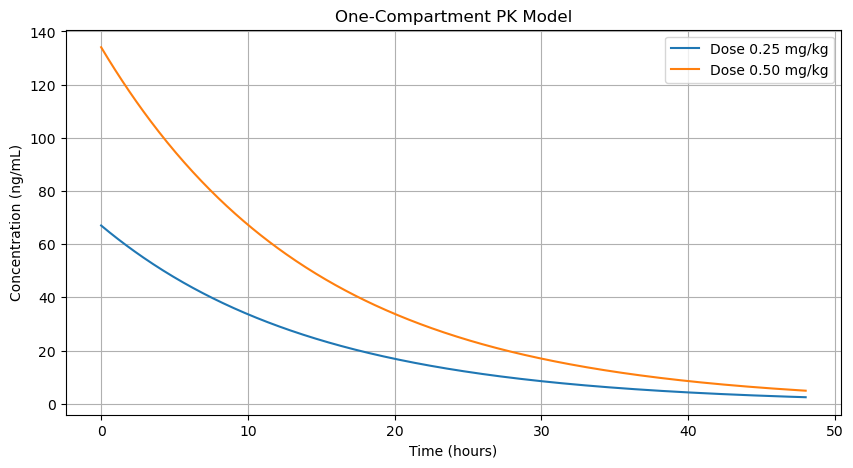

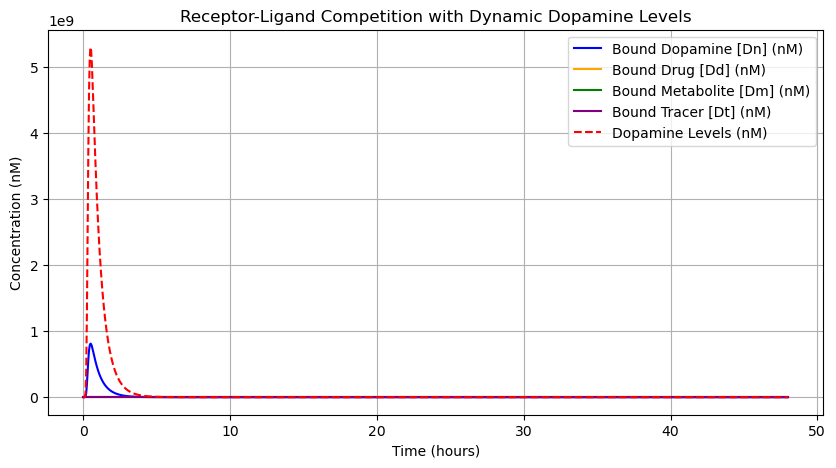

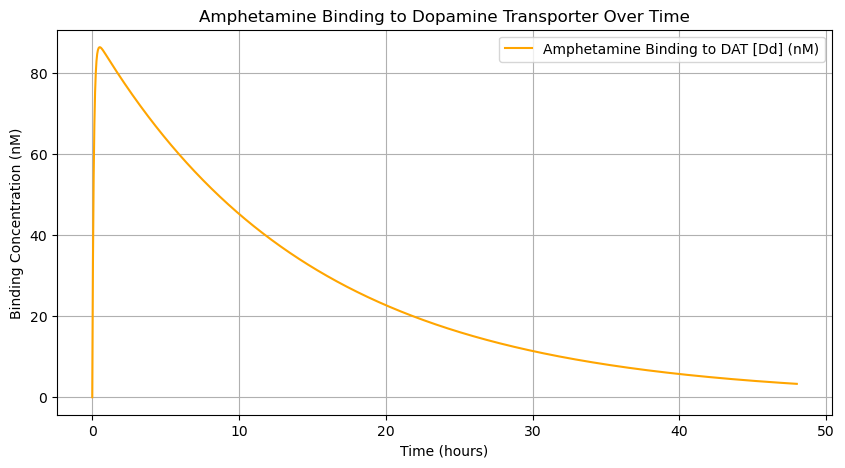

Max [Dn] (Bound dopamine): 812438364.595602 nM
Max [Dd] (Bound drug): 86.27186278153846 nM
Max [Dm] (Bound metabolite): 0.0 nM
Max [Dt] (Bound tracer): 0.0 nM
Max Dopamine Levels: 5303814890.498081 nM


In [29]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

# One-compartment pharmacokinetic (PK) model
def one_compartment_model(A, t, CL, V):
    dA_dt = -CL / V * A
    return dA_dt

# Parameters
BW = 70  # Body Weight (kg)
CL_per_kg = 0.257  # Clearance (L/h/kg)
V_per_kg = 3.73  # Volume of distribution (L/kg)
CL = CL_per_kg * BW * 1000  # Clearance (mL/h)
V = V_per_kg * BW * 1000  # Volume (mL)

# Doses in ng
dose_025 = 0.25 * BW * 1e6  # 0.25 mg/kg to ng
dose_050 = 0.5 * BW * 1e6    # 0.50 mg/kg to ng
t_pk = np.linspace(0, 48, 500)  # Time in hours

# Solve PK model for both doses
A_025 = odeint(one_compartment_model, dose_025, t_pk, args=(CL, V))
A_050 = odeint(one_compartment_model, dose_050, t_pk, args=(CL, V))
C_025 = A_025 / V  # Concentration (ng/mL)
C_050 = A_050 / V  # Concentration (ng/mL)

# DataFrames for plotting
df_025 = pd.DataFrame({'Time (h)': t_pk, 'Concentration (ng/mL)': C_025.flatten(), 'Dose': '0.25 mg/kg'})
df_050 = pd.DataFrame({'Time (h)': t_pk, 'Concentration (ng/mL)': C_050.flatten(), 'Dose': '0.50 mg/kg'})
combined_data = pd.concat([df_025, df_050])

# Plot PK results
plt.figure(figsize=(10, 5))
for dose, group in combined_data.groupby('Dose'):
    plt.plot(group['Time (h)'], group['Concentration (ng/mL)'], label=f'Dose {dose}')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (ng/mL)')
plt.title('One-Compartment PK Model')
plt.legend()
plt.grid()
plt.show()

# Dopamine decay function with drug effect
def dopamine_release(t, amphetamine_binding, base_release=1.0, amp_release_scale=1.5):
    return base_release * (1 + amp_release_scale * amphetamine_binding)

def dopamine_reuptake(dopamine_level, amphetamine_binding, base_reuptake=0.3, amp_inhib=0.8):
    return (base_reuptake * dopamine_level) * (1 - amp_inhib * amphetamine_binding)

# Receptor competition model with dynamic dopamine levels
def receptor_competition_with_amphetamine(y, t, K_on_dop, K_d_dop, K_on_drug, K_d_drug, K_on_met, K_d_met,
                                          K_on_tracer, K_d_tracer, Df, pk_conc, t_pk):
    Dn, Dd, Dm, Dt, dopamine_level = y
    drug_concentration = np.interp(t, t_pk, pk_conc)

    # Binding dynamics
    dDn_dt = K_on_dop * dopamine_level * Df - K_on_dop * K_d_dop * Dn
    dDd_dt = K_on_drug * drug_concentration * Df - K_on_drug * K_d_drug * Dd
    dDm_dt = K_on_met * 0 * Df - K_on_met * K_d_met * Dm
    dDt_dt = K_on_tracer * 0 * Df - K_on_tracer * K_d_tracer * Dt

    # Dopamine release and reuptake influenced by amphetamine binding
    dopamine_release_rate = dopamine_release(t, dDd_dt)  # Amphetamine binding boosts release
    dopamine_reuptake_rate = dopamine_reuptake(dopamine_level, dDd_dt)  # Binding inhibits reuptake
    dDopamine_dt = dopamine_release_rate - dopamine_reuptake_rate

    return [dDn_dt, dDd_dt, dDm_dt, dDt_dt, dDopamine_dt]

# Calibrated Parameters (adjust these based on literature)
molecular_weight = 153.18  # Molecular weight of the compound (g/mol)

# Conversion factors
ng_per_mL_to_nM = 1000 / molecular_weight  # Conversion factor from ng/mL to nM

# Parameters in nM
K_on_dop = 10e6 * ng_per_mL_to_nM   # Binding rate constant for dopamine (nM/h)
K_d_dop = 1.0 * ng_per_mL_to_nM    # Dissociation constant for dopamine (Kd) (nM)

K_on_drug = 1  # Binding rate constant for amphetamine (nM/h)
K_d_drug = 1.5 * ng_per_mL_to_nM   # Dissociation constant for amphetamine (Kd) (nM)

K_on_met = 0   # Binding rate constant for metabolite (nM/h)
K_d_met = 0    # Dissociation constant for metabolite (Kd) (nM)

K_on_tracer = 0  # Binding rate constant for tracer (nM/h)
K_d_tracer = 0  # Dissociation constant for tracer (Kd) (nM)

Df = 1.0         # Factor for binding dynamics (dimensionless)
base_release = 1.0  # Baseline dopamine release rate (nM/h)
amp_release_scale = 2.5  # Amphetamine’s effect on dopamine release rate (dimensionless)
base_reuptake = 0.3  # Baseline dopamine reuptake rate (nM/h)
amp_inhib = 0.75  # Amphetamine’s inhibition effect on reuptake (dimensionless)

# Initial conditions
initial_conditions = [0.0, 0.0, 0.0, 0.0, 0.0]  # Initial concentrations in nM
t_rc = np.linspace(0, 48, 1000)  # Time in hours
pk_concentrations = C_050.flatten() * ng_per_mL_to_nM  # Convert concentrations from PK model to nM

# Solve receptor competition model
solution_with_amp = odeint(receptor_competition_with_amphetamine, initial_conditions, t_rc,
                           args=(K_on_dop, K_d_dop, K_on_drug, K_d_drug, K_on_met, K_d_met,
                                 K_on_tracer, K_d_tracer, Df, pk_concentrations, t_pk))

# Extract solutions
Dn, Dd, Dm, Dt, dopamine_levels = solution_with_amp.T

# Plot receptor competition results
plt.figure(figsize=(10, 5))
plt.plot(t_rc, Dn, label='Bound Dopamine [Dn] (nM)', color='blue')
plt.plot(t_rc, Dd, label='Bound Drug [Dd] (nM)', color='orange')
plt.plot(t_rc, Dm, label='Bound Metabolite [Dm] (nM)', color='green')
plt.plot(t_rc, Dt, label='Bound Tracer [Dt] (nM)', color='purple')
plt.plot(t_rc, dopamine_levels, label='Dopamine Levels (nM)', color='red', linestyle='dashed')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (nM)')
plt.title('Receptor-Ligand Competition with Dynamic Dopamine Levels')
plt.legend()
plt.grid()
plt.show()

# Additional plot: Amphetamine binding to dopamine transporter (Dd)
plt.figure(figsize=(10, 5))
plt.plot(t_rc, Dd, label='Amphetamine Binding to DAT [Dd] (nM)', color='orange')
plt.xlabel('Time (hours)')
plt.ylabel('Binding Concentration (nM)')
plt.title('Amphetamine Binding to Dopamine Transporter Over Time')
plt.legend()
plt.grid()
plt.show()

# Print max values for each variable
print(f"Max [Dn] (Bound dopamine): {np.max(Dn)} nM")
print(f"Max [Dd] (Bound drug): {np.max(Dd)} nM")
print(f"Max [Dm] (Bound metabolite): {np.max(Dm)} nM")
print(f"Max [Dt] (Bound tracer): {np.max(Dt)} nM")
print(f"Max Dopamine Levels: {np.max(dopamine_levels)} nM")


In [ ]:
### Translate output of Rec-Comp to input for NEURON 





### Write CVS output file






### Translate DA binding rates to be read into NEURON simulation
# -*- coding: utf-8 -*-
"""
Created on Wed Oct  2 15:06:50 2024

@author: jmbouteiller
"""

import pandas as pd

DEBUG = False

df = pd.read_csv('data.csv', delimiter='\t', header=0 )

if (DEBUG): print(df.to_string()) 

# JMB: I used the the variables names for now
Nap_pyr_soma = df["Nap_pyr_soma"]
Nap_pyr_bas = df["Nap_pyr_bas"]
Hva_pyr_bas = df["Hva_pyr_bas"]
Hva_pyr_bas = df["Hva_pyr_bas"]
Iks_pyr_bas = df["Iks_pyr_bas"]
Nap_pyr_trunk = df["Nap_pyr_trunk"]
Hva_pyr_trunk = df["Hva_pyr_trunk"]
Iks_pyr_trunk = df["Iks_pyr_trunk"]
Hva_pyr_apical = df["Hva_pyr_apical"]
Iks_pyr_apical = df["Iks_pyr_apical"]
exex = df["exex"]
exin = df["exin"]
inex = df["inex"]
exexInterAssem = df["exexInterAssem"]
inin = df["inin"]
AMPAgEE = df["AMPAgEE"]
NMDAgEE = df["NMDAgEE"]
AMPAgEE_assem = df["AMPAgEE_assem"]
NMDAgEE_assem = df["NMDAgEE_assem"]
AMPAgEI = df["AMPAgEI"]
GABAgIE = df["GABAgIE"]
GABAgII = df["GABAgII"]



# Transpose if you prefer to work in the other dimension
"""
dftrans = df.transpose()
dftrans.to_csv('data_transposed.csv', sep='\t', encoding='utf-8', index=True, header=False)
"""

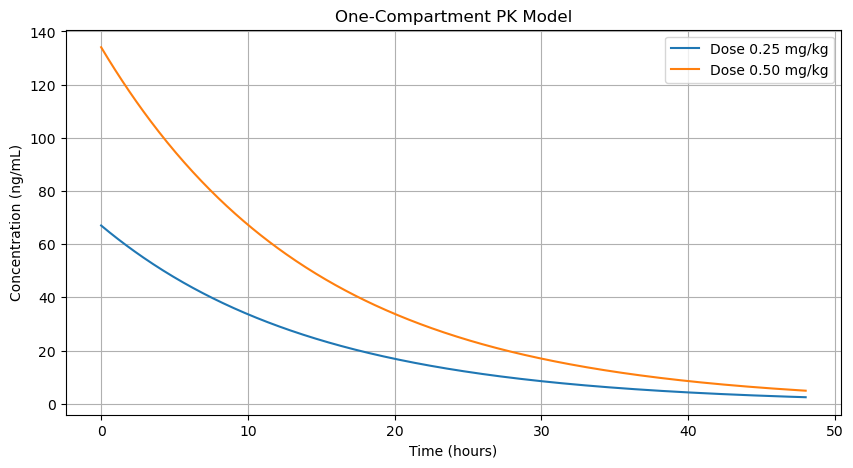

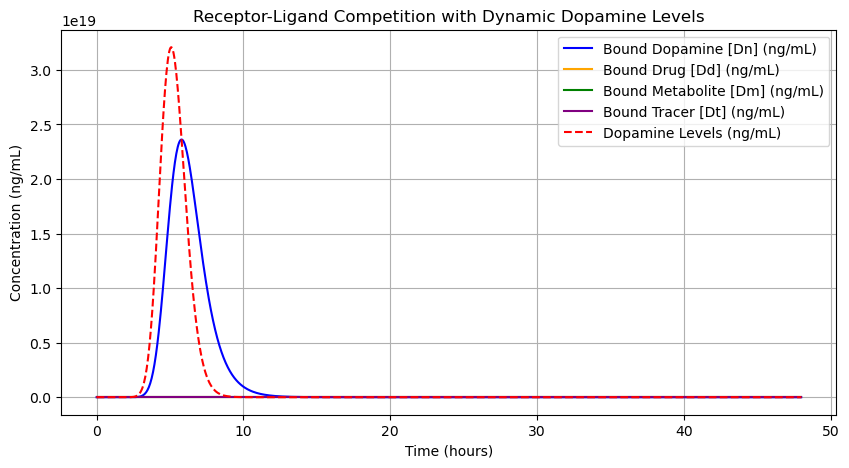

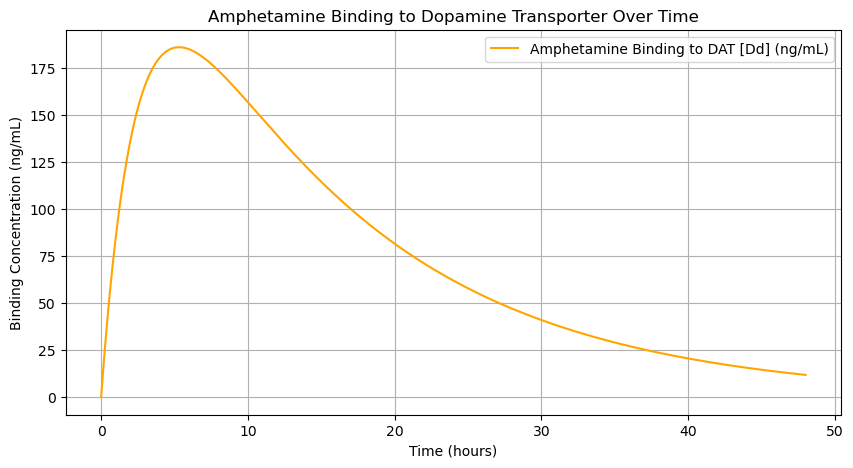

Max [Dn] (Bound dopamine): 2.3615457784503276e+19 ng/mL
Max [Dd] (Bound drug): 185.9250903900887 ng/mL
Max [Dm] (Bound metabolite): 0.0 ng/mL
Max [Dt] (Bound tracer): 0.0 ng/mL
Max [Dopamine levels]: 3.207879290189972e+19 ng/mL


In [25]:
## backup, PBPK model and Rceptor-Competition Model 
### ng/ml units. 

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd

# One-compartment pharmacokinetic (PK) model
def one_compartment_model(A, t, CL, V):
    dA_dt = -CL / V * A
    return dA_dt

# Parameters
BW = 70  # Body Weight (kg)
CL_per_kg = 0.257  # Clearance (L/h/kg)
V_per_kg = 3.73  # Volume of distribution (L/kg)
CL = CL_per_kg * BW * 1000  # Clearance (mL/h)
V = V_per_kg * BW * 1000  # Volume (mL)

# Doses in ng
dose_025 = 0.25 * BW * 1e6  # 0.25 mg/kg to ng
dose_050 = 0.5 * BW * 1e6    # 0.50 mg/kg to ng
t_pk = np.linspace(0, 48, 500)  # Time in hours

# Solve PK model for both doses
A_025 = odeint(one_compartment_model, dose_025, t_pk, args=(CL, V))
A_050 = odeint(one_compartment_model, dose_050, t_pk, args=(CL, V))
C_025 = A_025 / V  # Concentration (ng/mL)
C_050 = A_050 / V  # Concentration (ng/mL)

# DataFrames for plotting
df_025 = pd.DataFrame({'Time (h)': t_pk, 'Concentration (ng/mL)': C_025.flatten(), 'Dose': '0.25 mg/kg'})
df_050 = pd.DataFrame({'Time (h)': t_pk, 'Concentration (ng/mL)': C_050.flatten(), 'Dose': '0.50 mg/kg'})
combined_data = pd.concat([df_025, df_050])

# Plot PK results
plt.figure(figsize=(10, 5))
for dose, group in combined_data.groupby('Dose'):
    plt.plot(group['Time (h)'], group['Concentration (ng/mL)'], label=f'Dose {dose}')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (ng/mL)')
plt.title('One-Compartment PK Model')
plt.legend()
plt.grid()
plt.show()

# Dopamine decay function with drug effect
def dopamine_release(t, amphetamine_binding, base_release=1.0, amp_release_scale=1.5):
    return base_release * (1 + amp_release_scale * amphetamine_binding)

def dopamine_reuptake(dopamine_level, amphetamine_binding, base_reuptake=0.3, amp_inhib=0.8):
    return (base_reuptake * dopamine_level) * (1 - amp_inhib * amphetamine_binding)

# Receptor competition model with dynamic dopamine levels
def receptor_competition_with_amphetamine(y, t, K_on_dop, K_d_dop, K_on_drug, K_d_drug, K_on_met, K_d_met,
                                          K_on_tracer, K_d_tracer, Df, pk_conc, t_pk):
    Dn, Dd, Dm, Dt, dopamine_level = y
    drug_concentration = np.interp(t, t_pk, pk_conc)

    # Binding dynamics
    dDn_dt = K_on_dop * dopamine_level * Df - K_on_dop * K_d_dop * Dn
    dDd_dt = K_on_drug * drug_concentration * Df - K_on_drug * K_d_drug * Dd
    dDm_dt = K_on_met * 0 * Df - K_on_met * K_d_met * Dm
    dDt_dt = K_on_tracer * 0 * Df - K_on_tracer * K_d_tracer * Dt

    # Dopamine release and reuptake influenced by amphetamine binding
    dopamine_release_rate = dopamine_release(t, dDd_dt)  # Amphetamine binding boosts release
    dopamine_reuptake_rate = dopamine_reuptake(dopamine_level, dDd_dt)  # Binding inhibits reuptake
    dDopamine_dt = dopamine_release_rate - dopamine_reuptake_rate

    return [dDn_dt, dDd_dt, dDm_dt, dDt_dt, dDopamine_dt]

# Calibrated Parameters (adjust these based on literature)
K_on_dop = 1.0   # Binding rate constant for dopamine (1/ng/mL/h)
K_d_dop = 1.0    # Dissociation constant for dopamine (Kd) (ng/mL)
K_on_drug = 0.8  # Binding rate constant for amphetamine (1/ng/mL/h)
K_d_drug = 0.5   # Dissociation constant for amphetamine (Kd) (ng/mL)
K_on_met = 0.6   # Binding rate constant for metabolite (1/ng/mL/h)
K_d_met = 0.6    # Dissociation constant for metabolite (Kd) (ng/mL)
K_on_tracer = 0.4  # Binding rate constant for tracer (1/ng/mL/h)
K_d_tracer = 0.4   # Dissociation constant for tracer (Kd) (ng/mL)
Df = 1.0         # Factor for binding dynamics (dimensionless)
base_release = 1.0  # Baseline dopamine release rate (ng/mL/h)
amp_release_scale = 2.5  # Amphetamine’s effect on dopamine release rate (dimensionless)
base_reuptake = 0.3  # Baseline dopamine reuptake rate (ng/mL/h)
amp_inhib = 0.75  # Amphetamine’s inhibition effect on reuptake (dimensionless)

# Initial conditions
initial_conditions = [0.0, 0.0, 0.0, 0.0, 0.0]  # Initial concentrations in ng/mL
t_rc = np.linspace(0, 48, 1000)  # Time in hours
pk_concentrations = C_050.flatten()  # Concentrations from PK model (ng/mL)

# Solve receptor competition model
solution_with_amp = odeint(receptor_competition_with_amphetamine, initial_conditions, t_rc,
                           args=(K_on_dop, K_d_dop, K_on_drug, K_d_drug, K_on_met, K_d_met,
                                 K_on_tracer, K_d_tracer, Df, pk_concentrations, t_pk))

# Extract solutions
Dn, Dd, Dm, Dt, dopamine_levels = solution_with_amp.T

# Plot receptor competition results
plt.figure(figsize=(10, 5))
plt.plot(t_rc, Dn, label='Bound Dopamine [Dn] (ng/mL)', color='blue')
plt.plot(t_rc, Dd, label='Bound Drug [Dd] (ng/mL)', color='orange')
plt.plot(t_rc, Dm, label='Bound Metabolite [Dm] (ng/mL)', color='green')
plt.plot(t_rc, Dt, label='Bound Tracer [Dt] (ng/mL)', color='purple')
plt.plot(t_rc, dopamine_levels, label='Dopamine Levels (ng/mL)', color='red', linestyle='dashed')
plt.xlabel('Time (hours)')
plt.ylabel('Concentration (ng/mL)')
plt.title('Receptor-Ligand Competition with Dynamic Dopamine Levels')
plt.legend()
plt.grid()
plt.show()

# Additional plot: Amphetamine binding to dopamine transporter (Dd)
plt.figure(figsize=(10, 5))
plt.plot(t_rc, Dd, label='Amphetamine Binding to DAT [Dd] (ng/mL)', color='orange')
plt.xlabel('Time (hours)')
plt.ylabel('Binding Concentration (ng/mL)')
plt.title('Amphetamine Binding to Dopamine Transporter Over Time')
plt.legend()
plt.grid()
plt.show()

# Print max values for each variable
print(f"Max [Dn] (Bound dopamine): {np.max(Dn)} ng/mL")
print(f"Max [Dd] (Bound drug): {np.max(Dd)} ng/mL")
print(f"Max [Dm] (Bound metabolite): {np.max(Dm)} ng/mL")
print(f"Max [Dt] (Bound tracer): {np.max(Dt)} ng/mL")
print(f"Max [Dopamine levels]: {np.max(dopamine_levels)} ng/mL")
